In [1]:
import numpy as np
import matplotlib.pyplot as plt

(200, 1) (200, 1)


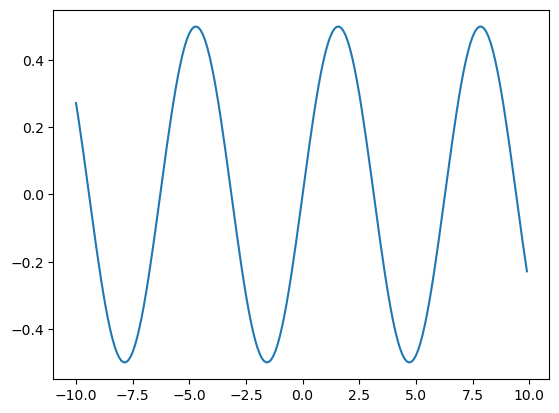

In [9]:
X = np.arange(-10,10,0.1).reshape(-1,1)
y = np.sin(X) * 1/2
print(X.shape, y.shape)
plt.plot(X[:, 0], y)

In [26]:
class Activation_ReLU:
    def forward(self, inputs):
        self.out = np.maximum(0, inputs)

class Layer_Dense:
    def __init__(self, n_inputs, n_outputs):
        self.weights = 0.01 * np.random.randn(n_inputs, n_outputs)
        self.biases = np.zeros((1, n_outputs))
    def forward(self, inputs):
        self.out = np.dot(inputs, self.weights) + self.biases

In [27]:
layer_1 = Layer_Dense(1, 3)
activation_1 = Activation_ReLU()
layer_1.forward(X)
activation_1.forward(layer_1.out)

In [28]:
print(activation_1.out[:5])

[[0.00475592 0.12943899 0.        ]
 [0.00470836 0.1281446  0.        ]
 [0.0046608  0.12685021 0.        ]
 [0.00461324 0.12555582 0.        ]
 [0.00456568 0.12426143 0.        ]]
